In [1]:
import numpy as np
import cv2
from cv2 import aruco, cvtColor, COLOR_BGR2GRAY, LUT
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
from funktionen import *
from scipy.sparse import lil_matrix
from scipy.optimize import least_squares
from scipy import stats

In [2]:
imgs = glob("../../serie1/*.jpg")

In [3]:
aruco_dict = aruco.extendDictionary(32, 3)
parameter = aruco.DetectorParameters()
parameter.cornerRefinementMethod = aruco.CORNER_REFINE_SUBPIX
LUT_IN = [0, 158, 216, 255]
LUT_OUT = [0, 22, 80, 176]
lut = np.interp(np.arange(0, 256),
                LUT_IN, LUT_OUT).astype(np.uint8)

In [4]:
corners = []
for j, imgPfad in enumerate(imgs):
    imgCV = cv2.imread(imgPfad)
    gray = cvtColor(imgCV, COLOR_BGR2GRAY)
    tmp_corners, tmp_ids, t = aruco.detectMarkers(
        gray, aruco_dict, parameters=parameter)
    """if j == 6 or j == 3:
        mimg = aruco.drawDetectedMarkers(
            imgCV, tmp_corners, tmp_ids, (255, 0, 0))
        print(mimg.shape)
        plt.imshow(mimg)
        plt.show()
        print(tmp_ids)
        cv.imwrite("mimg.jpg", mimg)"""
    for c, i in zip(tmp_corners, tmp_ids):
        size = np.linalg.norm(c[0][0] - c[0][1])
        # print(size)
        if size < 100:
            continue
        for k in range(len(c[0])):
            corners.append([j, i[0], k, c[0][k][0], c[0][k][1]])

In [5]:
corners = pd.DataFrame(corners, columns=["img", "marker", "ecke", "x", "y"])
corners.set_index(["img", "marker", "ecke"], inplace=True)
corners

x            y
img marker ecke                          
0   0      0     1969.539429   297.320587
           1     1981.801514   407.178833
           2     1852.734985   430.239105
           3     1833.315918   321.256836
    13     0      194.009140  2110.138184
...                      ...          ...
23  9      3     1180.403442   830.981873
    16     0     4285.006836   910.371643
           1     4060.363281   929.256897
           2     4059.873535   723.031067
           3     4284.933105   693.774963

[440 rows x 2 columns]

In [6]:
ca = corners.reset_index().set_index(["marker", "ecke"])
matched = ca.join(ca, lsuffix="_a", rsuffix="_b").query(
    'img_a < img_b').query("marker < 17")
matched.reset_index(inplace=True)
# matched.set_index(["img", "marker", "ecke"], inplace=True)
# matched.sort_index(inplace=True)
matched.query("img_a == 15").query("img_b==19")

marker  ecke  img_a          x_a          y_a  img_b          x_b  \
493        6     0     15   884.502808   907.102295     19  1871.490723   
508        6     1     15   936.664917  1001.101440     19  1882.373413   
523        6     2     15   828.039551  1095.947144     19  1736.613647   
538        6     3     15   770.387268  1003.304932     19  1723.334595   
706       10     0     15   262.316681   894.247986     19  1228.781128   
742       10     1     15   189.572861  1049.851562     19  1060.600098   
778       10     2     15    93.896339   916.116333     19  1037.125000   
814       10     3     15   172.339996   756.554199     19  1209.947388   
1058      14     0     15  1949.612183   371.254303     19  3186.217285   
1079      14     1     15  1959.941895   471.405273     19  3170.332520   
1100      14     2     15  1833.074097   477.550262     19  3034.104004   
1121      14     3     15  1817.902832   376.671631     19  3048.073486   
1152      15     0     15   364.952240  2036.244507     19   581.388977   
1167      15     1     15   446.436615  2104.971436     19   617.481140   
1182      15     2     15   423.238007  2277.337402     19   437.802429   
1197      15     3     15   337.085571  2214.423340     19   396.466034   
1211      16     0     15  1391.384277   184.328598     19  2616.482910   
1247      16     1     15  1260.676636   251.373505     19  2459.093018   
1283      16     2     15  1216.463135   112.517868     19  2464.463379   
1319      16     3     15  1353.077515    44.387970     19  2623.728516   

              y_b  
493   1482.888428  
508   1613.497559  
523   1629.731567  
538   1498.416382  
706    955.623108  
742    994.887146  
778    819.048523  
814    784.881409  
1058  1548.570435  
1079  1681.708862  
1100  1632.386963  
1121  1501.884644  
1152  1905.842896  
1167  2059.975342  
1182  2154.277832  
1197  1994.527344  
1211  1030.376587  
1247  1027.678101  
1283   872.845337  
1319   875.298889

In [7]:
best = matched.groupby(['img_a', 'img_b'])['marker'].count()      .reset_index(name='count') \
    .sort_values(['count'], ascending=False)
best

img_a  img_b  count
144     15     19     20
167     19     20     20
110     10     13     16
174     21     22     16
18       1      4     16
..     ...    ...    ...
94       8     11      4
91       7     21      4
90       7     15      4
1        0      2      4
88       7     12      4

[177 rows x 3 columns]

In [8]:
mtx = np.array([[3.48172482e+03, 0.00000000e+00, 2.30250916e+03],
                [0.00000000e+00, 3.47313834e+03, 1.31660435e+03],
                [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
mtx = np.array([[3442.2134, 0, 2307.9168],
                [0, 3442.2134, 1298.2032],
                [0,0,1]])
dist = np.array([-1.41372220e-02,  2.43909839e-01,
                1.15659062e-03,  1.28627153e-04,  -5.96950573e-01])
kameras = pd.DataFrame([[1, mtx[0, 0], mtx[1, 1], mtx[0, 2], mtx[1, 2],
                        dist[ 0], dist[1], dist[2], dist[ 3], dist[4]]],
                       columns=["kamera", "fx", "fy", "cx", "cy", "d1", "d2", "d3", "d4", "d5"]).astype({"kamera": int}).set_index("kamera")
kameras

fx         fy         cx         cy        d1       d2  \
kamera                                                                  
1       3442.2134  3442.2134  2307.9168  1298.2032 -0.014137  0.24391   

              d3        d4        d5  
kamera                                
1       0.001157  0.000129 -0.596951

In [9]:
bild1 = best['img_a'].values[0]
bild2 = best['img_b'].values[0]
pts = matched.reset_index()\
    .query("img_a == " + str(bild1))\
    .query("img_b == " + str(bild2))[["marker", "ecke", "x_a", "y_a", "x_b", "y_b"]].values
pts1 = pts[:, 2:4].astype(np.float32)
pts2 = pts[:, 4:].astype(np.float32)
pids = pts[:, :2].astype(np.float32)
len(pts1)

20

In [10]:
K1 = mtx
K2 = mtx

points1 = cart2hom(np.array(pts1).T)
points2 = cart2hom(np.array(pts2).T)

# Calculate essential matrix with 2d points.
# Result will be up to a scale
# First, normalize points
# Hartley p257
points1n = np.dot(np.linalg.inv(K1), points1)
points2n = np.dot(np.linalg.inv(K2), points2)
# cv2.undistortPoints(pts1, intrinsic, None)[:,0,:].T

print(len(points1n.T))

maxcount = 0
maxauswahl: NDArray[Any] | None = None

for i in range(1000):
    auswahl = choices(range(len(pts1)), k=8)

    E = compute_essential_normalized(
        points1n[:, auswahl], points2n[:, auswahl])

    mask = np.array([abs(points2n.T[i].T@E@points1n.T[i]) < 1
                    for i in range(len(points2n.T))])

    count = len(points2n.T[mask])
    if count > maxcount:
        maxcount = count
        maxauswahl = mask

points1n = points1n.T[maxauswahl].T
points2n = points2n.T[maxauswahl].T
pids = pids[maxauswahl]

E = compute_essential_normalized(points1n, points2n)

print('Computed essential matrix:', (-E / E[0][1]))

20
Computed essential matrix: [[ 1.14666277 -1.          0.89267427]
 [ 0.61774546 -0.61410997 -2.50974906]
 [-1.27888208  1.13456109 -0.23171373]]


In [11]:
P1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]], dtype=np.float32)
R1 = P1[:, :3]
t1 = P1[:, 3]
rod1, _ = cv2.Rodrigues(R1)

_, R, t, mask = cv2.recoverPose(E, points1n[:2].T, points2n[:2].T, np.eye(3))

R = np.linalg.inv(R)
t = -R@t

rod, _ = cv2.Rodrigues(R)

P2 = np.c_[R, t]
print(P2)

print(len(points1n.T))

[[ 0.71380869 -0.57782983  0.39571435 -0.66542452]
 [ 0.26877129  0.74778498  0.60710758 -0.74622816]
 [-0.64671412 -0.32700201  0.68907949  0.01880793]]
20


In [12]:
pictures = pd.DataFrame([[bild1, 0, 0, 0, 0, 0, 0], [
                        bild2, t[0][0], t[1][0], t[2][0], rod[0][0], rod[1][0], rod[2][0]]], columns=["img", "x", "y", "z", "r1", "r2", "r3"]).set_index("img")
# np.c_[t.T,rod.T]
pictures

x         y         z        r1        r2        r3
img                                                            
15   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
19  -0.665425 -0.746228  0.018808 -0.546921  0.610342  0.495685

In [13]:
mask = mask.ravel()
pids = pids[mask == 255]
points1n = points1n.T[mask == 255].T
points2n = points2n.T[mask == 255].T

In [14]:
tripoints3d = reconstruct_points(points1n, points2n, P1, P2)
# tripoints3d = structure.linear_triangulation(points1n, points2n, P1, P2)
tripoints3d /= tripoints3d[3]

In [15]:
coords = pd.DataFrame(list(zip(pids.T[0], pids.T[1], tripoints3d[0], tripoints3d[1],
                               tripoints3d[2])), columns=["marker", "ecke", "x", "y", "z"]).astype({"marker": int, "ecke": int}).set_index(["marker", "ecke"]).sort_index()

In [16]:
laenge = np.linalg.norm(coords.query("marker == 0").query("ecke == 0")[
    ["x", "y", "z"]].values - coords.query("marker == 0").query("ecke == 1")[["x", "y", "z"]].values)
if laenge > 0.0001:
    faktor = 0.034 / laenge

    coords["x"] *= faktor
    coords["y"] *= faktor
    coords["z"] *= faktor

    pictures["x"] *= faktor
    pictures["y"] *= faktor
    pictures["z"] *= faktor

In [17]:
def wolke_zeigen(coords, pictures):

    # pip install plotly

    import plotly.graph_objs as go

    c = np.array(pictures.values)

    for i in range(len(c)):
        R = cv2.Rodrigues(c[i, 3:])[0]
        R = np.linalg.inv(R)
        t = np.array(c[i, :3].T)
        t = -R@t
        c[i, 0:3] = t.T

    # Create a 3D scatter plot
    fig = go.Figure(data=[go.Scatter3d(x=coords['x'], y=coords['y'], z=coords['z'], mode='markers', name='Original Points'),
                          go.Scatter3d(x=c[:, 0], y=c[:, 1], z=c[:, 2],
                                       mode='markers', name='Kameras')])

    # Add labels to the plot
    fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                      title='Rotation and Translation Vectors in 3D')
    #fig.layout.scene.camera.projection.type = "orthographic"
    fig.show()


wolke_zeigen(coords, pictures)

In [18]:
def neues_bild(coords, pictures, kameras, corners):
    lp = corners.join(coords, lsuffix="_img", rsuffix="").query(
        "marker < 17").dropna().join(pictures, lsuffix="", rsuffix="_cam")
    lp = lp[lp["r1"].isnull()]
    bild = lp.groupby("img").count().sort_values(
        "x_img", ascending=False).first_valid_index()
    passpunkte = lp.query('img == ' + str(bild)).reset_index()
    pp = passpunkte[['x_img', 'y_img', 'x', 'y', 'z']].values
    if len(pp) >= 4:
        _, r, t, _ = cv2.solvePnPRansac(pp[:, 2:], pp[:, :2], mtx, None)
        rod, _ = cv2.Rodrigues(r)
        pictures = pd.concat([pictures, pd.DataFrame([[bild, t[0][0], t[1][0], t[2][0], r[0][0], r[1][0], r[2][0]]], columns=[
            "img", "x", "y", "z", "r1", "r2", "r3"]).set_index("img")])
    return pictures

In [19]:
def neue_koordinaten(coords, pictures, kameras):
    pic_a = pictures.reset_index().rename(
        columns={"img": "img_a"}).set_index("img_a")
    pic_b = pictures.reset_index().rename(
        columns={"img": "img_b"}).set_index("img_b")
    matched = ca.join(ca, lsuffix="_a", rsuffix="_b").query(
        'img_a < img_b').query("marker < 17").join(coords, lsuffix="", rsuffix="_ca")
    matched = matched[matched["x"].isnull()].reset_index().set_index([
        "img_a", "img_b"])
    matched = matched.join(pic_a, lsuffix="", rsuffix="_pic_a")
    matched = matched.join(pic_b, lsuffix="", rsuffix="_pic_b")
    matched.dropna(subset=['x_pic_a', 'x_pic_b'], inplace=True)
    matched = matched.reset_index().set_index(["marker", "ecke"])

    beste = matched.groupby(["marker"]).count().sort_values(
        "img_a", ascending=False)

    #print(beste)

    K = mtx
    for bester in beste.reset_index().values[:,0]:
        new = []
        #print(bester)
        for i in range(4):
            cneu = []
            
            for v in matched.query("marker =="+str(bester)).query("ecke =="+str(i))[['x_pic_a', 'y_pic_a', 'z_pic_a', 'r1', 'r2', 'r3', 'x_pic_b', 'y_pic_b', 'z_pic_b', 'r1_pic_b', 'r2_pic_b', 'r3_pic_b', 'x_a',	'y_a',	'x_b', 'y_b']].values:
                R1 = cv2.Rodrigues(v[3:6])[0]
                R2 = cv2.Rodrigues(v[9:12])[0]
                t1 = v[0:3]
                t2 = v[6:9]
                P1 = np.c_[R1, t1]
                P2 = np.c_[R2, t2]
                pt1 = v[12:14]
                pt2 = v[14:16]
                p1n = np.dot(np.linalg.inv(K), cart2hom(pt1))
                p2n = np.dot(np.linalg.inv(K), cart2hom(pt2))
                try: 
                    xy = reconstruct_one_point(p1n, p2n, P1, P2)
                    xy /= xy[3]
                    cneu.append(xy[0:3])
                except:
                    pass
            if len(cneu) == 0:
                continue
            data = pd.DataFrame(cneu, columns=["x", "y", "z"])
            #print(data['x'].std())
            if data['x'].std() > 0.2 or data['y'].std() > 0.2 or data['z'].std() > 0.2:
                #print(data)
                continue
            #print(data[(np.abs(stats.zscore(data)) < 2).all(axis=1)])
            median = data.mean().values
            new.append([bester, i, median[0], median[1], median[2]])
        #print(new)
        if len(new) == 4:
            new = pd.DataFrame(new, columns=["marker", "ecke", "x", "y", "z"]).set_index(["marker", "ecke"])
            coords = pd.concat([coords, new])
            return coords
    return coords

In [20]:
pictures = neues_bild(coords, pictures, kameras, corners)

In [21]:
coords = neue_koordinaten(coords, pictures, kameras)

In [22]:
for i in range(24):
    pictures = neues_bild(coords, pictures, kameras, corners)
    coords = neue_koordinaten(coords, pictures, kameras)

In [23]:
wolke_zeigen(coords, pictures)

### Ausrichtung

In [24]:
def ausrichten(coords, pictures):
    bodenpunkte = coords.query("marker == 0 or marker == 6 or marker == 15 or marker == 3 or marker == 11 or marker == 13 or marker == 14 or marker == 4").query(
        "ecke == 1 or ecke == 2")
    hoeherepunkte = coords.query("marker == 0 or marker == 6 or marker == 15 or marker == 3 or marker == 11 or marker == 13 or marker == 14 or marker == 4").query(
        "ecke == 0 or ecke == 3")

    t_boden = bodenpunkte.mean().values
    vec2 = hoeherepunkte.mean()- t_boden
    laenge = np.linalg.norm(vec2)
    vec2 /= laenge
    b = vec2.values
    faktor = 0.034 / laenge

    a = np.array([0, 0, 1])

    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))

    coords[['x', 'y', 'z']] -= t_boden
    coords[['x', 'y', 'z']] *= faktor
    coords[['x', 'y', 'z']] = coords[['x', 'y', 'z']].dot(rotation_matrix)

    for pict in pictures.values:
        t = pict[0:3].T
        R_org = cv2.Rodrigues(pict[3:])[0]
        R = np.linalg.inv(R_org)
        t = -R@t
        R_neu = np.linalg.inv(rotation_matrix@R_org)
        pict[0:3] = -R_neu@(((t-t_boden)*faktor)@rotation_matrix).T
        pict[3:] = cv2.Rodrigues(R_neu)[0].T
    return coords, pictures

In [25]:
def vergleich(imgs, coords, pictures, kameras):
    d = []
    for nr in pictures.index:
        r = pictures.query("img == "+str(nr))[["r1", "r2", "r3"]].values
        t = pictures.query("img == "+str(nr))[["x", "y", "z"]].values
        kp = kameras.query("kamera == 1").values
        mtx = np.array([[kp[0][0], 0, kp[0][2]], [
            0, kp[0][1], kp[0][3]], [0, 0, 1]])
        dist = kp[0][4:]
        img_points, _ = cv2.projectPoints(coords.values, r, t, mtx, dist)
        img_points = pd.DataFrame(
            img_points.reshape(-1, 2), columns=["x_neu", "y_neu"])
        img_points['img'] = nr
        img_points[["marker", "ecke"]] = coords.reset_index()[
            ["marker", "ecke"]]
        img_points.set_index(["marker", "ecke", "img"], inplace=True)
        j = img_points.join(corners, lsuffix="_neu", rsuffix="_alt").dropna()
        j['dx'] = j['x_neu'] - j['x']
        j['dy'] = j['y_neu'] - j['y']
        j['d'] = np.sqrt(j['dx']**2 + j['dy']**2)
        
        if (j[['d']].std().values[0] > 40):
            print("Entferne Bild ", nr+1)
            pictures.drop(nr, inplace=True)
        elif j[j['d']>15].count().values[0] > 1:
            for i in j[j['d']>15].index:
                print("Entferne Passpunkt ", i)
                print(i)
                coords.drop(i[:2], inplace=True)



#vergleich(imgs, coords, pictures, kameras)

### Ausgleichung

In [26]:
def ausgleichung(coords, pictures, kameras, corners):
    lp = corners.join(coords, lsuffix="_img", rsuffix="").query(
     "marker < 17").join(pictures, lsuffix="", rsuffix="_cam").dropna()

    kamera = kameras.reset_index().values
    kamera_ids = np.array(kamera[:, 0], dtype=np.int32)

    bilder = pictures.reset_index().values
    bilder = np.c_[np.ones(len(bilder)), bilder]
    bilder_ids = np.array(bilder[:, :2], dtype=np.int32)

    passpunkte = coords.reset_index().values
    passpunkte_ids = np.array(passpunkte[:, :2], dtype=np.int32)

    messung = lp.reset_index().values[:, :5]
    messung_ids = np.array(messung[:, :3], dtype=np.int32)

    l = np.array(messung[:, -2:].ravel(), dtype=np.float64)

    x0 = np.hstack((kamera[:, 1:].ravel(),
                    bilder[:, 2:].ravel(), passpunkte[:, 2:].ravel()))

    A = lil_matrix((len(l), len(x0)), dtype=int)

    n_camera = len(kamera)
    n_bilder = len(bilder)
    n_passpunkte = len(passpunkte)
    n_messungen = len(messung)
    messung_bild_id = np.empty(n_messungen, dtype=np.int32)
    messung_kamera_id = np.empty(n_messungen, dtype=np.int32)
    messung_passpunkt_id = np.empty(n_messungen, dtype=np.int32)
    num_cam_param = 9
    num_bild_param = 6
    num_pass_param = 3

    for i, m in enumerate(messung):
        bild_id, = np.where(bilder_ids[:, 1] == m[2])
        bild_id = bild_id[0]
        messung_bild_id[i] = bild_id

        camera_id_array,  = np.where(kamera_ids[:] == bilder[bild_id, 0])
        camera_id = camera_id_array[0]
        messung_kamera_id[i] = camera_id

        passpunkt_id_array, = np.where(
            (passpunkte_ids[:, 0] == m[0]) & (passpunkte_ids[:, 1] == m[1]))
        passpunkt_id = passpunkt_id_array[0]
        messung_passpunkt_id[i] = passpunkt_id

        offset = camera_id*num_cam_param
        A[2*i:2*i+2, offset:offset+num_cam_param] = 1

        offset = n_camera * num_cam_param + bild_id * num_bild_param
        A[2*i:2*i+2, offset:offset + num_bild_param] = 1

        offset = n_camera*num_cam_param + n_bilder * \
            num_bild_param + passpunkt_id * num_pass_param
        A[2*i:2*i+2, offset:offset + num_pass_param] = 1

    def project(x0: NDArray[np.float32]) -> NDArray[np.float32]:
        p = np.empty(len(l), dtype=np.float32)

        K = []
        dist = []
        for i in range(n_camera):
            offset = i * num_cam_param
            fx = x0[offset]
            fy = x0[offset + 1]
            cx = x0[offset + 2]
            cy = x0[offset + 3]
            K.append(np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]]))
            dist.append(np.array([x0[offset + 4], x0[offset + 5],
                                x0[offset + 6], x0[offset + 7], x0[offset + 8]]))

        r = []
        t = []
        for i in range(n_bilder):
            offset = n_camera * num_cam_param + \
                i*num_bild_param

            t.append(x0[offset:offset+3])
            r.append(x0[offset+3:offset+6])

        X = []
        for i in range(n_passpunkte):
            offset = n_camera * num_cam_param + \
                n_bilder*num_bild_param + \
                num_pass_param * i
            X.append(x0[offset:offset+3].reshape(1, 3))

        for i, m in enumerate(messung):
            punkt, _ = cv2.projectPoints(
                X[messung_passpunkt_id[i]], r[messung_bild_id[i]], t[messung_bild_id[i]], K[messung_kamera_id[i]], dist[messung_kamera_id[i]])
            # print(i*2+1)
            p[i*2] = punkt[0, 0, 0]
            p[i*2+1] = punkt[0, 0, 1]

        return p.ravel()-l

    res = least_squares(project, x0, jac_sparsity=A, verbose=2, 
                        x_scale='jac', method='trf', ftol=1e-4)  # type: ignore

    x = res.x

    kameras = pd.DataFrame(np.c_[kamera_ids, x[:num_cam_param * n_camera].reshape(n_camera, num_cam_param)],
                        columns=["kamera", "fx", "fy", "cx", "cy", "d1", "d2", "d3", "d4", "d5"]).astype({"kamera": int}).set_index("kamera")

    offset = num_cam_param * n_camera
    pictures = pd.DataFrame(np.c_[bilder_ids[:, 1], x[offset:offset+num_bild_param*n_bilder].reshape(
        n_bilder, num_bild_param)], columns=["img", "x", "y", "z", "r1", "r2", "r3"]).astype({"img": int}).set_index("img")

    offset = num_cam_param * n_camera + num_bild_param*n_bilder
    coords = pd.DataFrame(np.c_[passpunkte_ids, x[offset:offset+num_pass_param*n_passpunkte].reshape(n_passpunkte, num_pass_param)],
                        columns=["marker", "ecke", "x", "y", "z"]).astype({"marker": int, "ecke": int}).set_index(["marker", "ecke"])

    #print(project(x).reshape(-1, 2))
    return res, kameras, pictures, coords

In [30]:
res, kameras, pictures, coords = ausgleichung(coords, pictures, kameras, corners)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.8873e+05                                    9.39e+06    
       1              2         4.8484e+05      3.89e+03       7.88e+00       7.16e+06    
       2              3         4.4314e+05      4.17e+04       9.10e-01       5.71e+06    
       3              4         4.3740e+05      5.75e+03       5.90e-01       3.11e+06    
       4              5         4.2608e+05      1.13e+04       4.44e-01       7.62e+06    
       5              6         4.1308e+05      1.30e+04       2.04e-01       6.04e+06    
       6              7         4.0506e+05      8.02e+03       3.09e-01       2.70e+06    
       7              8         3.9467e+05      1.04e+04       6.92e-01       7.26e+06    
       8              9         3.8623e+05      8.45e+03       1.52e-01       3.80e+06    
       9             10         3.8512e+05      1.11e+03       7.15e-02       5.34e+06    

#### Kontrolle

In [31]:
wolke_zeigen(coords, pictures)

15


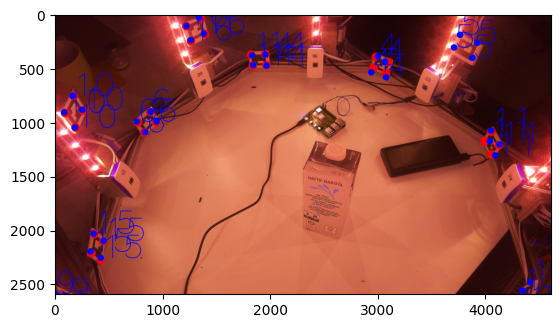

19


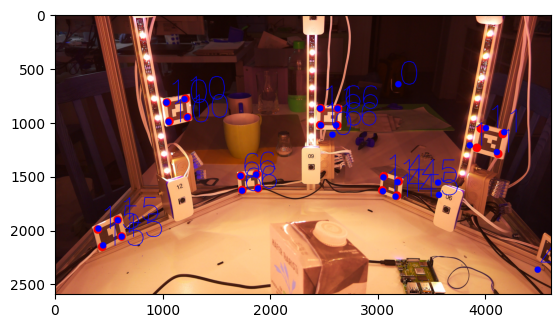

20


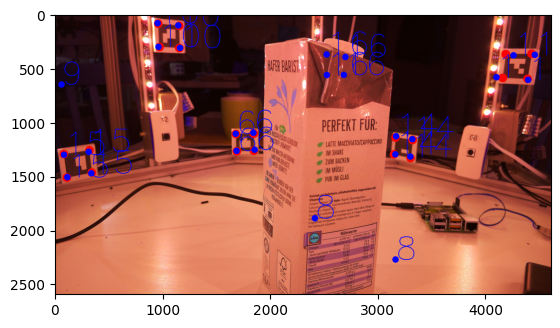

22


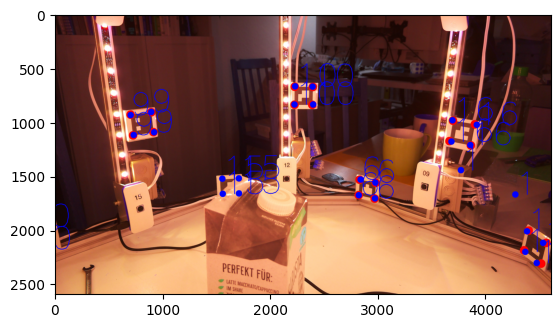

16


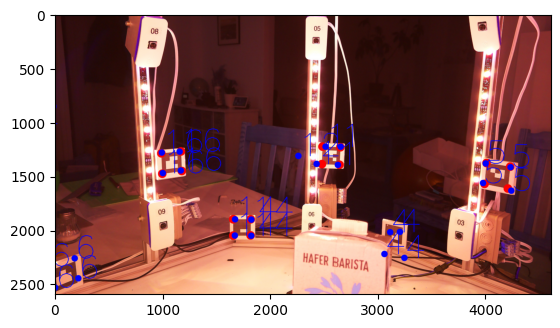

18


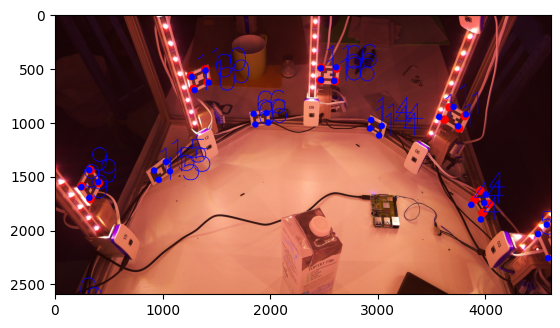

21


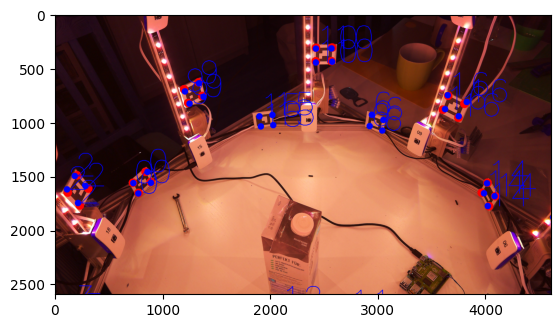

1


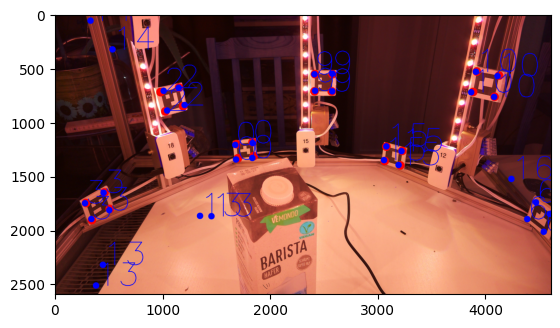

0


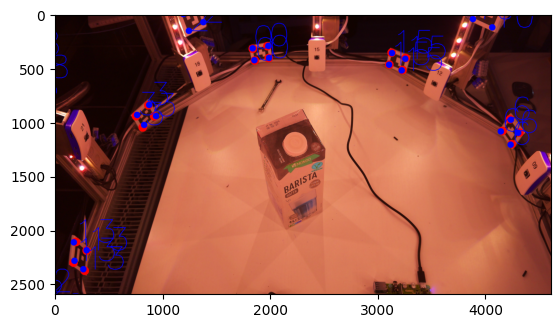

2


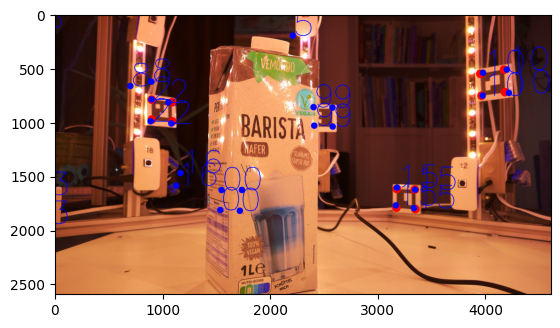

4


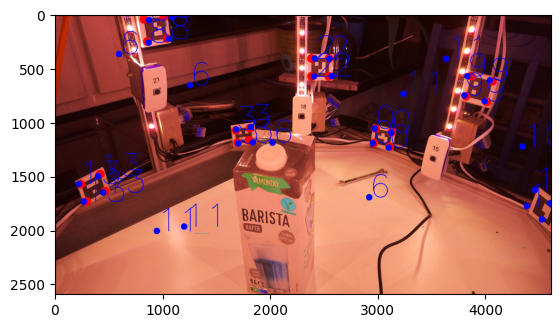

9


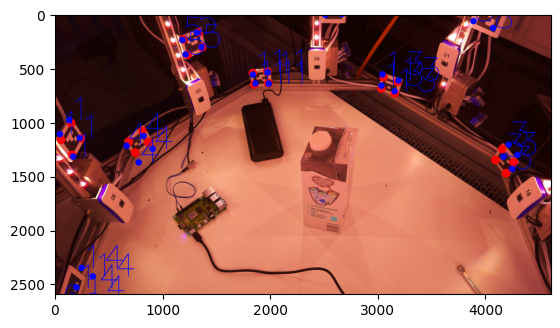

3


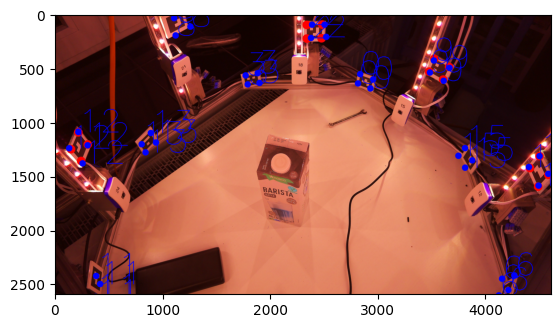

7


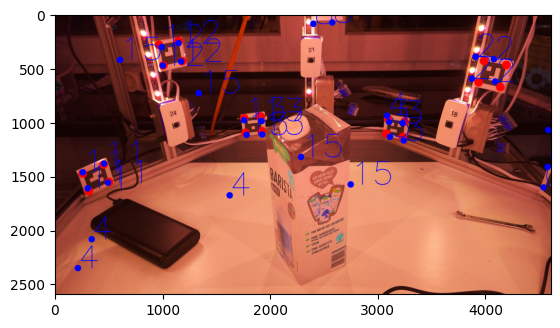

10


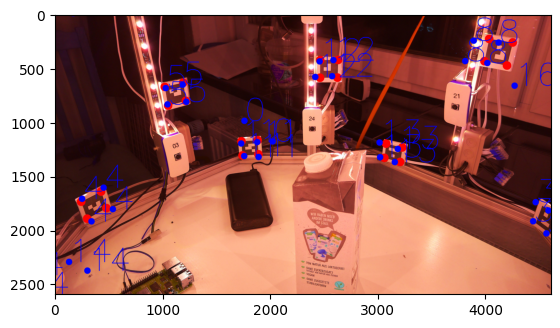

13


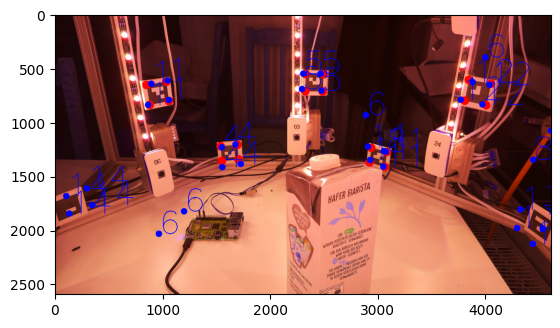

6


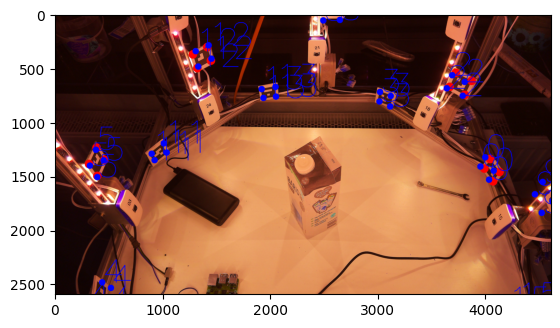

8


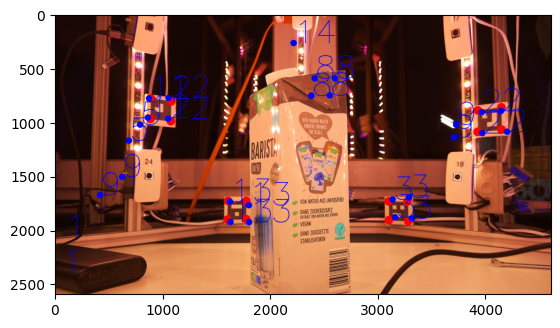

11


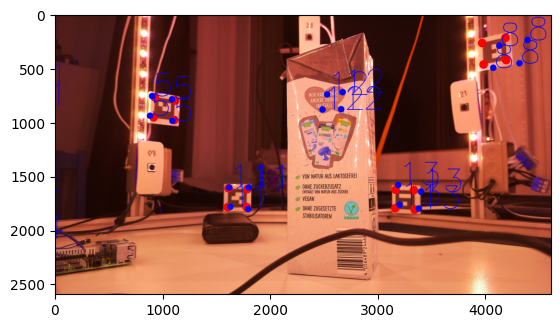

12


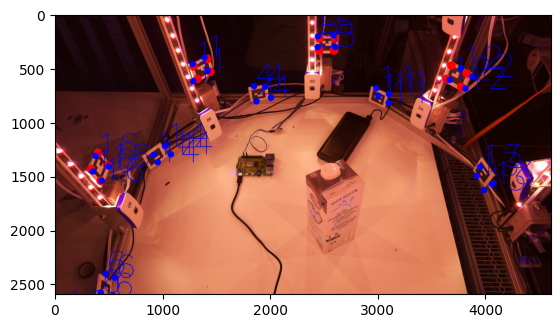

5


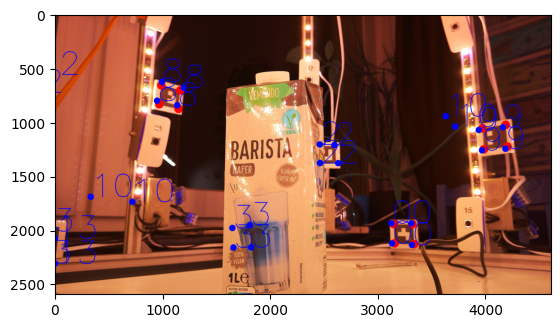

23


KeyboardInterrupt: 

In [42]:
def zeige_auf_bildern(imgs, coords, pictures, kameras):
    for nr in pictures.index:
        print(nr)
        imgCV = cv2.imread(imgs[nr])
        r = pictures.query("img == "+str(nr))[["r1", "r2", "r3"]].values
        t = pictures.query("img == "+str(nr))[["x", "y", "z"]].values
        kp = kameras.query("kamera == 1").values
        mtx = np.array([[kp[0][0], 0, kp[0][2]], [
                    0, kp[0][1], kp[0][3]], [0, 0, 1]])
        dist = kp[0][4:]
        for p in corners.query("img == "+str(nr)).values:
            cv2.circle(imgCV, (int(p[0]), int(p[1])), 40, (255, 0, 0), -1)
        img_points, _ = cv2.projectPoints(coords.values, r, t, mtx, dist)
        for c,p in zip(coords.reset_index()['marker'].values,img_points):
            try:
                cv2.circle(imgCV, (int(p[0][0]), int(p[0][1])), 30, (0, 0, 255), -1)
                cv2.putText(imgCV, str(c), (int(p[0][0]), int(
                    p[0][1])), cv2.FONT_HERSHEY_SIMPLEX, 10, (0, 0, 255), 5)
            except:
                pass
        plt.imshow(imgCV)
        plt.show()

zeige_auf_bildern(imgs, coords, pictures, kameras)